# Data Preparation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('udc_dataset_no_duplicate_titles.csv')
df.head()

,uid,text,udc_1,udc_2,udc_3,udc_4,udc_5,type,generated_title,desc_custom_id,generated_description
0,0,A Beida,1¢(533.22),NaN,NaN,NaN,NaN,book,Exploring Contemporary Philosophies at Beida,0-request-book-0,"""Exploring Contemporary Philosophies at Beida""..."
1,0,A Beida,1¢(533.22),NaN,NaN,NaN,NaN,book,Exploring Chinese Culture in Modern Times,0-request-book-1,"""Exploring Chinese Culture in Modern Times"" of..."
2,0,A Beida,1¢(533.22),NaN,NaN,NaN,NaN,book,Whispers of the Old Library,0-request-book-2,"In ""Whispers of the Old Library,"" A Beida weav..."
3,0,A Beida,1¢(533.22),NaN,NaN,NaN,NaN,book,Whispers of the Eastern Lotus,0-request-book-3,"""Whispers of the Eastern Lotus"" is a captivati..."
4,0,A Beida,1¢(533.22),NaN,NaN,NaN,NaN,article,Investigating the Differential Genetic Express...,0-request-sci-0,This article explores the variations in geneti...


In [ ]:
# I'll ignore multi-labels for now.
df_cut = df[[' udc_1', 'generated_title', 'generated_description']].copy()

# Also remove periods
df_cut[' udc_1'] = df_cut[' udc_1'].apply(lambda x: x.strip().replace('.', ''))
df_cut.head()

,udc_1,generated_title,generated_description
0,1¢(53322),Exploring Contemporary Philosophies at Beida,"""Exploring Contemporary Philosophies at Beida""..."
1,1¢(53322),Exploring Chinese Culture in Modern Times,"""Exploring Chinese Culture in Modern Times"" of..."
2,1¢(53322),Whispers of the Old Library,"In ""Whispers of the Old Library,"" A Beida weav..."
3,1¢(53322),Whispers of the Eastern Lotus,"""Whispers of the Eastern Lotus"" is a captivati..."
4,1¢(53322),Investigating the Differential Genetic Express...,This article explores the variations in geneti...


In [4]:
# This pruned one will be used for a simple category classification
df_tag_pruned = df_cut.copy()
df_tag_pruned[' udc_1'] = df_tag_pruned[' udc_1'].apply(lambda x: x.strip()[:4])
df_tag_pruned.head()

,udc_1,generated_title,generated_description
0,1¢(5,Exploring Contemporary Philosophies at Beida,"""Exploring Contemporary Philosophies at Beida""..."
1,1¢(5,Exploring Chinese Culture in Modern Times,"""Exploring Chinese Culture in Modern Times"" of..."
2,1¢(5,Whispers of the Old Library,"In ""Whispers of the Old Library,"" A Beida weav..."
3,1¢(5,Whispers of the Eastern Lotus,"""Whispers of the Eastern Lotus"" is a captivati..."
4,1¢(5,Investigating the Differential Genetic Express...,This article explores the variations in geneti...


In [5]:
def udc_to_list(udc):
    """Convert UDC code to a list of its components."""
    list_udc = []
    for i in udc:
        list_udc.append(i)
    return list_udc

udc_to_list('hello')

['h', 'e', 'l', 'l', 'o']

In [6]:
text_values = df[['generated_title', 'generated_description']].copy()
text_values.head()

,generated_title,generated_description
0,Exploring Contemporary Philosophies at Beida,"""Exploring Contemporary Philosophies at Beida""..."
1,Exploring Chinese Culture in Modern Times,"""Exploring Chinese Culture in Modern Times"" of..."
2,Whispers of the Old Library,"In ""Whispers of the Old Library,"" A Beida weav..."
3,Whispers of the Eastern Lotus,"""Whispers of the Eastern Lotus"" is a captivati..."
4,Investigating the Differential Genetic Express...,This article explores the variations in geneti...


In [7]:
text_values_cat = text_values['generated_title'] + ' ' + text_values['generated_description']
text_values_cat.head()

0    Exploring Contemporary Philosophies at Beida "...
1    Exploring Chinese Culture in Modern Times "Exp...
2    Whispers of the Old Library In "Whispers of th...
3    Whispers of the Eastern Lotus "Whispers of the...
4    Investigating the Differential Genetic Express...
dtype: object

# Data processing

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [9]:
vectorizer = TfidfVectorizer()

In [10]:
param_grid_vectorizer = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'vectorizer__max_df': [0.5, 0.75 , 0.9], # We only have theoretically 7 samples per class, so a int can be used
              'vectorizer__min_df': [1,2, 3,5,7]} # Since there are some niche categories, float values are not used
              




## Train/Test Split

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

# Get the total number of samples
total_samples = len(df_tag_pruned) # All are same size, so we can use any of them
indices = np.arange(total_samples)

# First split: 80% train+val, 20% test
trainval_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Second split: from the 80%, take 80% for train and 20% for validation
# This gives us 64% train, 16% val, 20% test
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.2, random_state=42)

print(f"Total samples: {total_samples}")
print(f"Train samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Test samples: {len(test_idx)}")

Total samples: 37373
Train samples: 23918
Validation samples: 5980
Test samples: 7475


In [12]:
x_train = text_values_cat[trainval_idx]
#x_val = text_values_cat[val_idx]  # We're using gridsearch, so we don't need a separate validation set
x_test = text_values_cat[test_idx]

# Std KNN

In [13]:
# Starting with the simplest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [14]:
std_pruning_knn = KNeighborsClassifier()
knn_args = {'knn__n_neighbors': range(3,7)}
le = LabelEncoder()

In [16]:
y_train_std_pruning = le.fit_transform(df_tag_pruned[' udc_1'])[trainval_idx]
y_test_std_pruning = le.transform(df_tag_pruned[' udc_1'])[test_idx]


In [17]:
len(le.classes_)

1201

In [17]:
from sklearn.model_selection import GridSearchCV

In [24]:
std_pruning_knn_pipe = Pipeline([
    ('vectorizer', vectorizer),
    ('knn', std_pruning_knn)
])

In [56]:
# Concatenate the parameter grid for vectorizer and knn
grid_search_param_grid_std_pruning = param_grid_vectorizer.copy()
grid_search_param_grid_std_pruning.update(knn_args)
grid_search_param_grid_std_pruning

{'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
 'vectorizer__max_df': [0.7, 0.8, 0.9, 1, 20, 50, 100, 300],
 'vectorizer__min_df': [1, 3, 5, 7],
 'knn__n_neighbors': range(3, 7)}

In [47]:
from sklearn.model_selection import KFold

In [48]:
folder = KFold(n_splits=3, shuffle=True, random_state=42)

In [57]:
std_pruning_cv = GridSearchCV(
    std_pruning_knn_pipe,
    param_grid=grid_search_param_grid_std_pruning,
    scoring='balanced_accuracy',
    cv=folder,
    n_jobs=2,
    verbose=1)

In [26]:
from time import time

In [58]:
start_time = time()
std_pruning_cv.fit(x_train, y_train_std_pruning)
print(f"Best parameters: {std_pruning_cv.best_params_}")
print(f"Best score: {std_pruning_cv.best_score_}")
end_time = time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, ro

Best parameters: {'knn__n_neighbors': 3, 'vectorizer__max_df': 300, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score: 0.6841692621312259
Training time: 4677.55 seconds


#### Saving

In [31]:
import pickle

In [59]:
with open('std_pruning_knn_model.pkl', 'wb') as f:
    pickle.dump(std_pruning_cv, f)

with open('std_pruning_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Sep KNN

In [33]:
df_exploded = df_cut.copy()
df_exploded[' udc_1'] = df_exploded[' udc_1'].apply(lambda x: x.strip()[:10]).apply(udc_to_list)
# We could add more values later (by expanding :10 to :12 or more)
cat_values = df_exploded[' udc_1'].apply(pd.Series).fillna('no_value')
cat_values

,0,1,2,3,4,5,6,7,8,9
0,1,¢,(,5,3,3,2,2,),no_value
1,1,¢,(,5,3,3,2,2,),no_value
2,1,¢,(,5,3,3,2,2,),no_value
3,1,¢,(,5,3,3,2,2,),no_value
4,1,¢,(,5,3,3,2,2,),no_value
...,...,...,...,...,...,...,...,...,...,...
37368,6,2,1,6,0,6,5,no_value,no_value,no_value
37369,6,2,1,6,0,6,5,no_value,no_value,no_value
37370,6,2,1,6,0,6,5,no_value,no_value,no_value
37371,6,2,1,6,0,6,5,no_value,no_value,no_value


In [34]:
y_train_sep_cat_list = []
for i in cat_values.columns:
    y_train_sep_cat_list.append(cat_values[i][trainval_idx])

# Now we have a df for each #number
print(len(y_train_sep_cat_list))
y_train_sep_cat_list[0]

10


10378    1
27852    6
12757    6
25950    5
18146    3
        ..
16850    5
6265     3
11284    6
860      6
15795    1
Name: 0, Length: 29898, dtype: object

In [35]:
# Import pickle to save the model
import pickle

In [36]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

### Training

In [54]:
total_start_time = time()
for it_num, y_train in enumerate(y_train_sep_cat_list):
    le = LabelEncoder() 
    y_train_label_encoded = le.fit_transform(y_train)
    model_output_name = f"knn_value_{it_num}"
    labelencoder_output_name = f"labelencoder_value_{it_num}"
    
    output_dir = 'model_output'
    model_output_path = f"{output_dir}/{model_output_name}.pkl"
    knn_sep_cat = KNeighborsClassifier()
    pipe_sep_cat = Pipeline([
        ('vectorizer', vectorizer),
        ('knn', knn_sep_cat)
    ])
    #sep_cat_param_grid = {'vectorizer__ngram_range': [(1,3), (1,4)]} #param_grid_vectorizer.copy()
    sep_cat_param_grid = param_grid_vectorizer.copy()
    sep_cat_param_grid.update({'knn__n_neighbors': range(3,7)}) # As we have less categories, maybe we can use more neighbors

    best_sep_cat_cv = HalvingGridSearchCV(
        pipe_sep_cat,
        param_grid=sep_cat_param_grid,
        scoring='balanced_accuracy',
        cv=folder,
        n_jobs=2,
        factor=2,
        verbose=0,
        error_score=0 
    )
    start_time = time()
    best_sep_cat_cv.fit(x_train, y_train_label_encoded)
    end_time = time()
    print(f"Best parameters for category {it_num}: {best_sep_cat_cv.best_params_}")
    print(f"Best score for category {it_num}: {best_sep_cat_cv.best_score_}")
    print(f"Training time for category {it_num}: {end_time - start_time:.2f} seconds")
    print(f"Saving model for category {it_num} to {model_output_path}")
    with open(model_output_path, 'wb') as f:
        pickle.dump(best_sep_cat_cv, f)
    
    with open(f"{output_dir}/{labelencoder_output_name}.pkl", 'wb') as f:
        pickle.dump(le, f)
        

final_end_time = time()
print(f"Total training time for all categories: {final_end_time - total_start_time:.2f} seconds")

c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 0: {'knn__n_neighbors': 3, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 0: 0.7624290868388884
Training time for category 0: 253.91 seconds
Saving model for category 0 to model_output/knn_value_0.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 1: {'knn__n_neighbors': 3, 'vectorizer__max_df': 100, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 1: 0.5631207445827141
Training time for category 1: 194.95 seconds
Saving model for category 1 to model_output/knn_value_1.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 2: {'knn__n_neighbors': 3, 'vectorizer__max_df': 100, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 2: 0.5002611639806529
Training time for category 2: 226.54 seconds
Saving model for category 2 to model_output/knn_value_2.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 3: {'knn__n_neighbors': 3, 'vectorizer__max_df': 100, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 3: 0.5156959586359365
Training time for category 3: 229.18 seconds
Saving model for category 3 to model_output/knn_value_3.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 4: {'knn__n_neighbors': 3, 'vectorizer__max_df': 20, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 4: 0.45701134724061016
Training time for category 4: 191.66 seconds
Saving model for category 4 to model_output/knn_value_4.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 5: {'knn__n_neighbors': 3, 'vectorizer__max_df': 20, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 5: 0.4469712430926787
Training time for category 5: 165.54 seconds
Saving model for category 5 to model_output/knn_value_5.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 6: {'knn__n_neighbors': 3, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 6: 0.4616842219590178
Training time for category 6: 261.50 seconds
Saving model for category 6 to model_output/knn_value_6.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 7: {'knn__n_neighbors': 3, 'vectorizer__max_df': 20, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 7: 0.4783441754992766
Training time for category 7: 177.86 seconds
Saving model for category 7 to model_output/knn_value_7.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 8: {'knn__n_neighbors': 3, 'vectorizer__max_df': 20, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 3)}
Best score for category 8: 0.4008100000846649
Training time for category 8: 225.18 seconds
Saving model for category 8 to model_output/knn_value_8.pkl


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
108 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, rout

Best parameters for category 9: {'knn__n_neighbors': 5, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best score for category 9: 0.2654586847045124
Training time for category 9: 142.95 seconds
Saving model for category 9 to model_output/knn_value_9.pkl
Total training time for all categories: 2071.40 seconds


In [51]:
le.inverse_transform(best_sep_cat_cv.predict(['avian avian avian bird ave']))

array(['5'], dtype=object)

In [ ]:
cat_values[0].value_counts()

0
6    13902
1     8028
5     7934
3     3624
7     1472
0     1031
2      651
8      454
9      271
4        6
Name: count, dtype: int64

In [ ]:
np.save('test_idx.npy', test_idx)

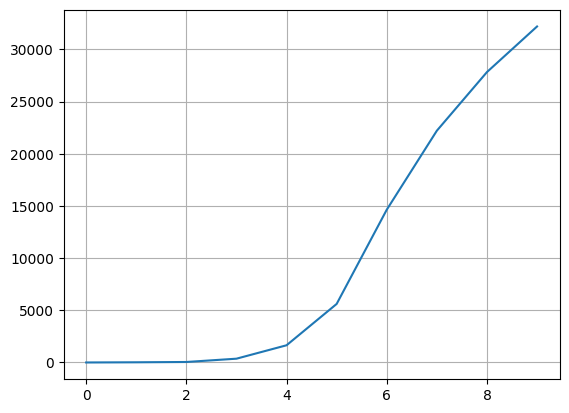

In [ ]:
# Check how many NaNs 
column_nan_dict = {}
for column in cat_values_na_visualization.columns:
    column_nan_dict[column] = cat_values_na_visualization[column].isna().sum()

plt.plot(column_nan_dict.keys(), column_nan_dict.values())
plt.grid()
plt.show()